# Course Lead Scoring - Classification

## Load the Bank Marketing dataset

In [1]:
# Read dataset
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

data = 'course_lead_scoring.txt'
df = pd.read_csv(data)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

## Data preparation
- Check if the missing values are presented in the features.
- If there are missing values:
    - For categorical features, replace them with 'NA'
    - For numerical features, replace with with 0.0

In [4]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [2]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [3]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
cat = df.select_dtypes(include=['object']).columns
num = df.select_dtypes(exclude=['object']).columns
df[cat] = df[cat].fillna('NA')
df[num] = df[num].fillna(0.0)
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### Question 1
What is the most frequent observation (mode) for the column industry?
- NA
- technology
- healthcare
- retail

In [6]:
df.industry.mode()

0    retail
Name: industry, dtype: object

### Question 2

Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

- interaction_count and lead_score
- number_of_courses_viewed and lead_score
- number_of_courses_viewed and interaction_count
- annual_income and interaction_count

Only consider the pairs above when answering this question.

interaction_count ↔ lead_score: 0.010
number_of_courses_viewed ↔ lead_score: -0.005
number_of_courses_viewed ↔ interaction_count: -0.024
annual_income ↔ interaction_count: 0.027


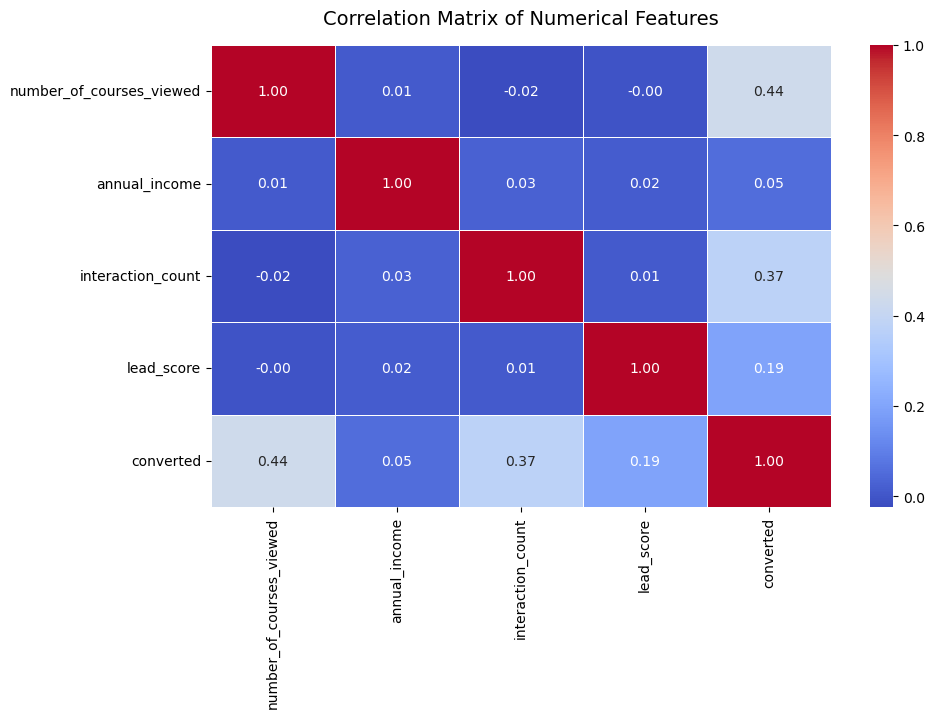

In [9]:
# Compute correlation matrix
corr_matrix = df[num].corr()

# Display correlation values for the given pairs
pairs = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]

for a, b in pairs:
    print(f"{a} ↔ {b}: {corr_matrix.loc[a, b]:.3f}")

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Correlation Matrix of Numerical Features", fontsize=14, pad=15)

# Display the plot
plt.show()

## Split the data

- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value converted is not in your dataframe.

In [12]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 3
- Calculate the mutual information score between converted and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).

Which of these variables has the biggest mutual information score?
- industry
- location
- lead_source
- employment_status

In [16]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Step 1: Select categorical columns
categorical = df[cat].columns

# Step 2: Encode categorical columns (convert to numeric)
df_train_encoded = df_train.copy()

for col in categorical:
    encoder = LabelEncoder()
    df_train_encoded[col] = encoder.fit_transform(df_train_encoded[col].astype(str))

# Step 3: Calculate mutual information between features and target
mi_scores = mutual_info_classif(
    df_train_encoded[categorical],
    y_train,  
    discrete_features=True,
    random_state=42
)

# Step 4: Format and display results
mi_scores = pd.Series(mi_scores, index=categorical).sort_values(ascending=False).round(2)
print(mi_scores)

lead_source          0.04
employment_status    0.01
industry             0.01
location             0.00
dtype: float64


### Question 4
- Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?
- 0.64
- 0.74
- 0.84
- 0.94

In [18]:
# Prepare data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Categorical columns
categorical = ['industry', 'location', 'lead_source', 'employment_status']

# Numerical columns
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

# One-hot encode categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(df_train[categorical])

X_train_cat = pd.DataFrame(
    ohe.transform(df_train[categorical]),
    columns=ohe.get_feature_names_out(categorical)
)
X_val_cat = pd.DataFrame(
    ohe.transform(df_val[categorical]),
    columns=ohe.get_feature_names_out(categorical)
)

# Combine numerical and one-hot encoded categorical features
X_train = pd.concat([df_train[numerical].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_val = pd.concat([df_val[numerical].reset_index(drop=True), X_val_cat.reset_index(drop=True)], axis=1)

y_train = y_train  # target
y_val = y_val

C:\Users\My Pham\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
# Train the LR model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [22]:
# Evaluation on validation set
y_pred = model.predict(X_val)
accuracy = round(accuracy_score(y_val, y_pred),3)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.7


### Question 5
- Let's find the least useful feature using the feature elimination technique.
- Train a model using the same features and parameters as in Q4 (without rounding).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?
- 'industry'
- 'employment_status'
- 'lead_score'

Note: The difference doesn't have to be positive.

In [23]:
# Store the original accuracy
# Original model accuracy
original_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
original_model.fit(X_train, y_train)
y_pred_orig = original_model.predict(X_val)
original_accuracy = accuracy_score(y_val, y_pred_orig)
print("Original Accuracy:", original_accuracy)

Original Accuracy: 0.6996587030716723


In [26]:
X_train.columns

Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', 'industry_NA', 'industry_education', 'industry_finance',
       'industry_healthcare', 'industry_manufacturing', 'industry_other',
       'industry_retail', 'industry_technology', 'location_NA',
       'location_africa', 'location_asia', 'location_australia',
       'location_europe', 'location_middle_east', 'location_north_america',
       'location_south_america', 'lead_source_NA', 'lead_source_events',
       'lead_source_organic_search', 'lead_source_paid_ads',
       'lead_source_referral', 'lead_source_social_media',
       'employment_status_NA', 'employment_status_employed',
       'employment_status_self_employed', 'employment_status_student',
       'employment_status_unemployed'],
      dtype='object')

In [27]:
# Define features to test
feature_groups = {
    'industry': [col for col in X_train.columns if col.startswith('industry')],
    'employment_status': [col for col in X_train.columns if col.startswith('employment_status')],
    'lead_score': ['lead_score']  # numeric column
}
accuracy_diffs = {}

In [29]:
# Drop one feature at a time and calculate the difference
for feature, cols in feature_groups.items():
    X_train_drop = X_train.drop(columns=cols)
    X_val_drop = X_val.drop(columns=cols)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_drop, y_train)
    y_pred_drop = model.predict(X_val_drop)
    
    acc_diff = original_accuracy - accuracy_score(y_val, y_pred_drop)
    accuracy_diffs[feature] = acc_diff

accuracy_diffs

{'industry': 0.0,
 'employment_status': 0.0034129692832763903,
 'lead_score': -0.0068259385665528916}

### Question 6
- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these C leads to the best accuracy on the validation set?
- 0.01
- 0.1
- 1
- 10
- 100

Note: If there are multiple options, select the smallest C.

In [33]:
C_values = [0.01, 0.1, 1, 10, 100]
val_accuracies = {}

for C in C_values:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    acc = round(accuracy_score(y_val, y_pred), 3)
    
    val_accuracies[C] = acc

val_accuracies

{0.01: 0.7, 0.1: 0.7, 1: 0.7, 10: 0.7, 100: 0.7}

In [32]:
# Get the C value with the highest accuracy
best_C = min([c for c, acc in val_accuracies.items() if acc == max(val_accuracies.values())])
best_C

0.01